In [622]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

In [623]:
data = pd.read_csv('./CC_GENERAL.csv')
data.head()
data.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


### Предварительная обработка данных
Необходимо избавиться от переменных, которые не нужны для кластеризации. Удалим столбец CUST_ID, так как он имеет уникальные значения.

In [624]:
data = data.drop(['CUST_ID'], axis=1)

Проверим, присутствуют ли пропущенные значения. 

In [625]:
data.isna().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

у параметров `CREDIT_LIMIT` и `MINIMUM_PAYMENTS` есть пропущенные значения. 
Поскольку набор данных предназначен для кластеризации, при вменении будет использоваться `KNNImputer`, чтобы избежать смещения результатов кластеризации. Пропущенные значения каждой выборки вычисляются с использованием среднего значения от ближайших соседей n_neighbors, найденных в обучающем наборе.

In [626]:
null_columns = data.columns[data.isnull().any()].tolist()
imputer = KNNImputer()
imp_data = pd.DataFrame(imputer.fit_transform(data[null_columns]), columns=null_columns)
data = data.fillna(imp_data)

# повторно проверим и убедимся, что теперь нет пропущенных значений
data.isna().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

### Масштабируем данные
Масштабирование функций является важным шагом, когда единицы функций отличаются друг от друга. Масштабирование необходимо, поскольку оно управляет изменчивостью набора данных, преобразует данные в определенный диапазон с помощью линейного преобразования для получения высококачественных кластеров и повышает точность алгоритмов кластеризации. 

В данном случае воспользуемся `StandardScaler` из библиотеки `sklearn` для стандартизации признаков.

In [627]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(pd.DataFrame(data)))

### Уменьшаем размерность
Метод K-Means плохо работает с данными высокой размерности из-за "проклятия размерности". Используем PCA для уменьшения размерности.

In [628]:
scaled_data = np.asarray(scaled_data)
pca = PCA(n_components=2, random_state=42)
scaled_data = pca.fit_transform(scaled_data)

### Определим количество кластеров
Метод K-Means предполагает, что мы определяем количество кластеров заранее. Найдем оптимальное число кластеров с помощью Elbow Method.

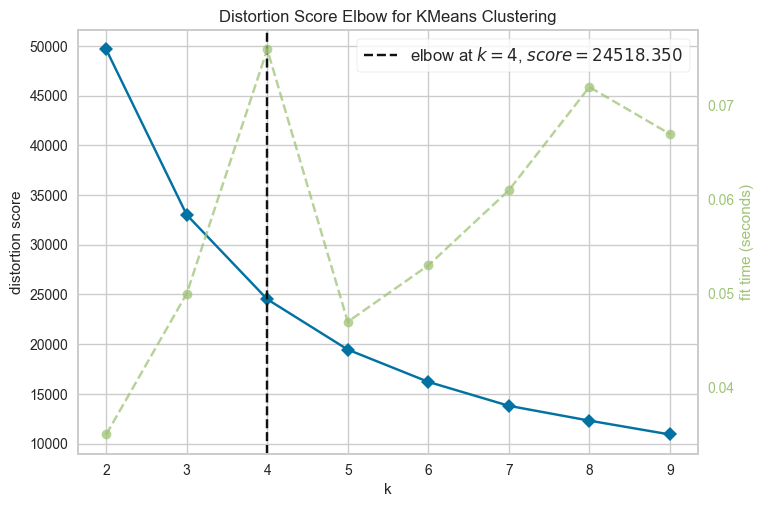

Основываясь на результатах Elbow Method, можно сделать вывод, что лучшее число кластеров для алгоритма K-Means составляет 4 кластера.


In [629]:
random_state=42
model = KMeans()
elbow_visualizer = KElbowVisualizer(model, k=(2, 10))

elbow_visualizer.fit(scaled_data)       
elbow_visualizer.show()
print(f"Основываясь на результатах Elbow Method, можно сделать вывод, что лучшее число кластеров для алгоритма K-Means составляет {elbow_visualizer.elbow_value_} кластера.")

In [630]:
km_model = KMeans(elbow_visualizer.elbow_value_)
y_kmeans  = km_model.fit_predict(scaled_data)

### Метрики для оценки качества кластеризации

Для оценки качества кластеризации можно использовать следующие метрики: Индекс Дэвиса-Болдина (Davies-Bouldin index), Коэффициент силуэта (silhouette score), Calinski-Harabasz index
- Davies-Bouldin index определяется как соотношение между разбросом кластеров и их разделением. Минимальный балл равен нулю. **Чем ниже балл, тем лучше кластеризация**.
- Silhouette Score. Коэффициент силуэта определяется для каждого образца и состоит из двух показателей:
    - Среднее расстояние между образцом и всеми другими точками в том же классе. `a`
    - Среднее расстояние между образцом и всеми другими точками в следующем ближайшем кластере. `b`

Коэффициент силуэта для одного образца определяется как `(b - a) / max(a, b)`. Значение варьируется от -1 до 1. **Более высокий показатель коэффициента силуэта относится к модели с более четкими кластерами.**

- Calinski-Harabasz index - отношение суммы межкластерной дисперсии и межкластерной дисперсии для всех кластеров. **Чем выше показатель, тем лучше качество результатов кластеризации.**

In [631]:
db_score = round(davies_bouldin_score(scaled_data, y_kmeans), 3)
s_score = round(silhouette_score(scaled_data, y_kmeans), 3)
ch_index = round(calinski_harabasz_score(scaled_data, y_kmeans), 3)
print(f'Davies-Bouldin index: {db_score}')
print(f'Silhouette Score: {s_score}')
print(f'Calinski Harabasz Index: {ch_index}')

Davies-Bouldin index: 0.801
Silhouette Score: 0.408
Calinski Harabasz Index: 5823.678


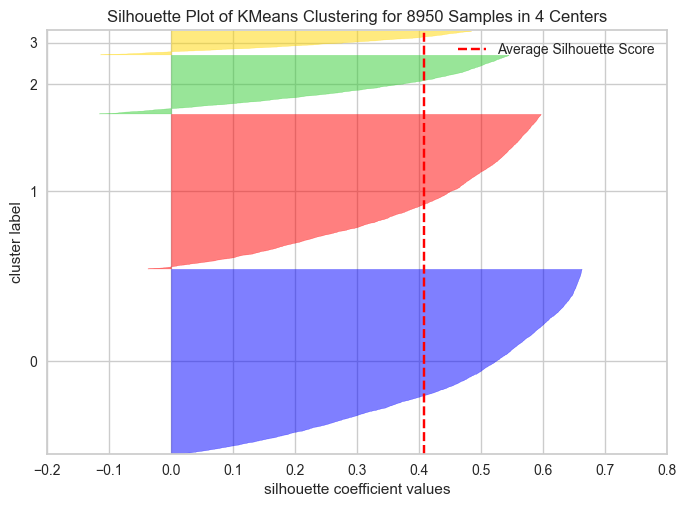

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 8950 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [632]:
cluster_colors=['blue', 'red', 'limegreen', 'gold', 'pink', 'yellow', 'brown']
visualizer = SilhouetteVisualizer(km_model, colors=cluster_colors)
visualizer.fit(pd.DataFrame(scaled_data))

visualizer.show()

Вертикальная пунктирная красная линия на этом графике — это средний балл, а значит результаты каждого кластера выше среднего, метод кластеризации работает хорошо.

### Как выбор начальных центров кластеров влияет на результат кластеризации
Из графика выше видно, что значение силуэта каждого кластера выше среднего, что говорит о том, что все кластеры являются оптимальными.

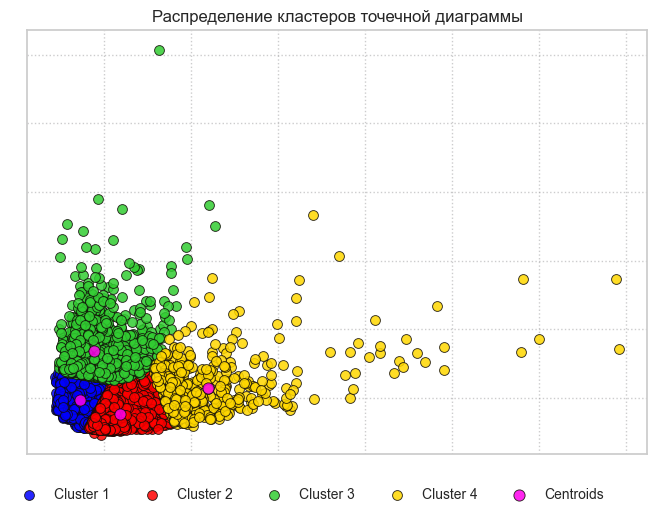

In [633]:
y_kmeans_labels = list(set(y_kmeans.tolist()))
scatter_style=dict(linewidth=0.65, edgecolor='#100C07', alpha=0.85)

# Create an array of labels for the clusters
labels = [f"Cluster {i+1}" for i in range(elbow_visualizer.elbow_value_)]
labels.append("Centroids")

for i in y_kmeans_labels:
    plt.scatter(scaled_data[y_kmeans==i, 0], scaled_data[y_kmeans == i, 1], s=50, c=cluster_colors[i], **scatter_style)
plt.scatter(km_model.cluster_centers_[:, 0], km_model.cluster_centers_[:, 1], s=65, c='#ff00ee', label='Centroids', **scatter_style)

plt.title('Распределение кластеров точечной диаграммы')
plt.legend(labels, bbox_to_anchor=(0.95, -0.05), ncol=5)
plt.grid(axis='both', alpha=0.5, color='#9B9A9C', linestyle='dotted')
plt.tick_params(left=False, right=False , labelleft=False , labelbottom=False, bottom=False)

При смене параметра `random_state` для функции `KMeans()` и повторном запуске, видно, что выбор начального центра, зависящий от параметра `random_state`, играет большую роль на результат кластеризации пограничных значений. Алгоритм k-средних чувствителен к выбору начальных центров кластеров.

Примеры кластеризации для разных начальных центров:

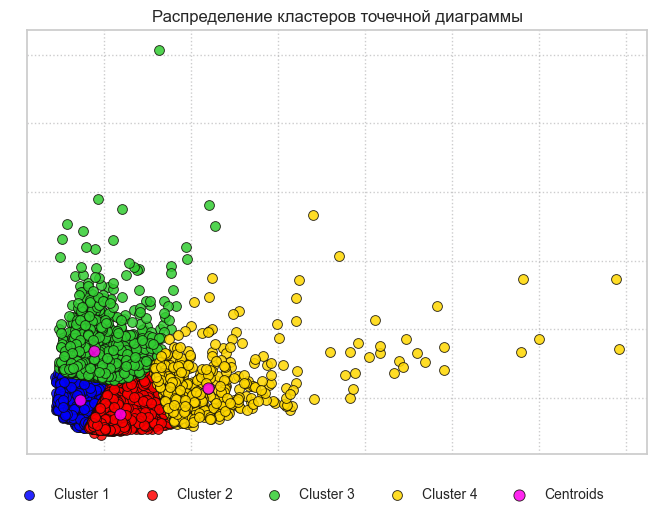

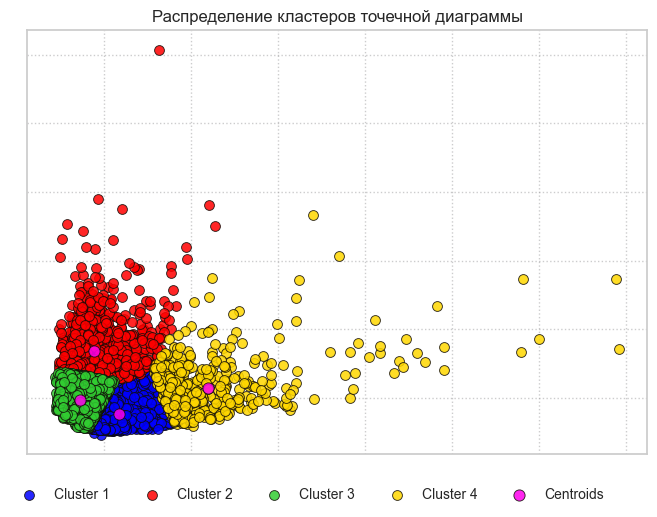

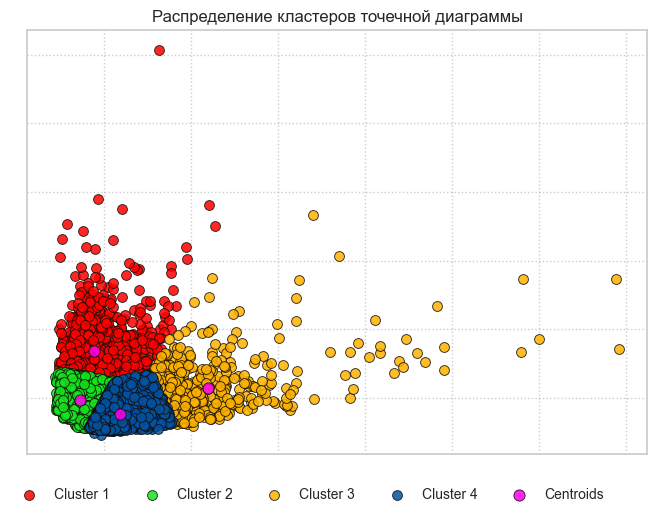
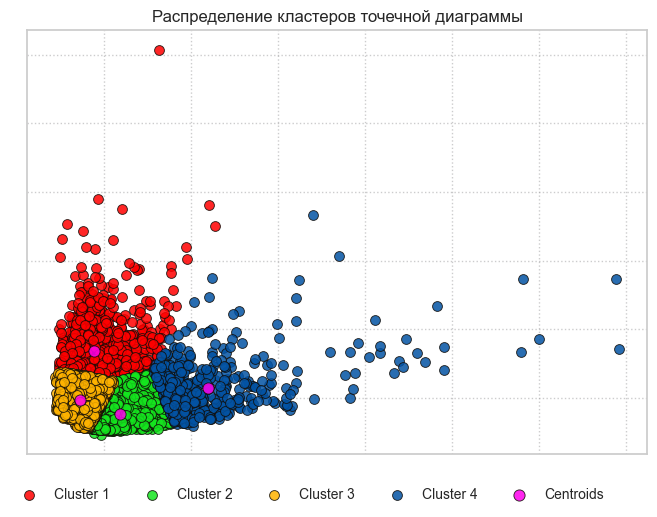
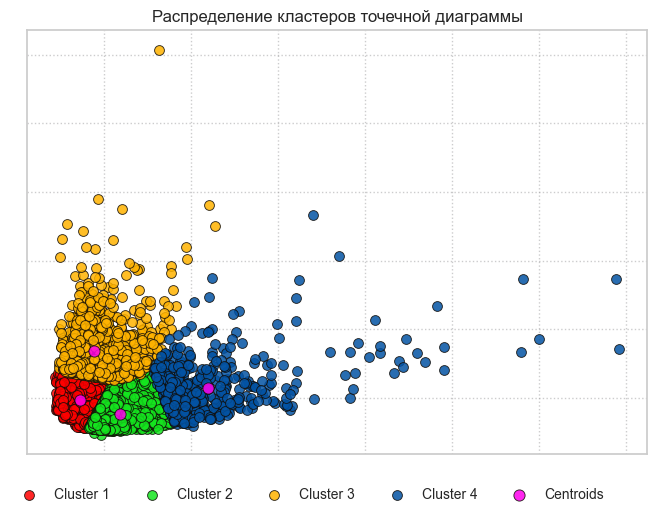